In [1]:
# imports
import sys  
sys.path.insert(0, '../../../TwitterCoordinatedInorganicAgents')

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel
from transformers import AutoTokenizer
import numpy as np
from tweetcore.tasks.postgres_target import download_data
from tweetcore.tasks.classification_task.utils import make_report  
from data_builders.tasks import collapse_embeddings
import credentials_refactor
import global_settings as gs
import gc

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model utils
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Getting data ready

In [2]:
# data
conf = credentials_refactor.return_credentials()
data = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query = '''
                                                          select *
                                                          from redacted_tables.features_user_classification
                                                          limit 10000
                                                          ''')

# User-based classifier

## Getting data ready

In [3]:
user_based_features = [i for i in data.columns if 'uuu' in i]

In [4]:
df_user = data[user_based_features + ["target"]].copy()

In [5]:
df_user.fillna(-1,inplace=True)


In [6]:
cast_to_int = ['uuu_year_joined', 'uuu_month_joined', 'uuu_day_of_month_joined', 'uuu_day_of_week_joined', 'uuu_hour_joined']
for i in cast_to_int:
    df_user.loc[:,i] = df_user[i].astype(int)

In [7]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   uuu_year_joined                        10000 non-null  int32  
 1   uuu_month_joined                       10000 non-null  int32  
 2   uuu_day_of_month_joined                10000 non-null  int32  
 3   uuu_day_of_week_joined                 10000 non-null  int32  
 4   uuu_joined_weekend                     10000 non-null  int64  
 5   uuu_hour_joined                        10000 non-null  int32  
 6   uuu_username_length                    10000 non-null  int64  
 7   uuu_fraction_numbers_username          10000 non-null  float64
 8   uuu_fraction_emojis_username           10000 non-null  float64
 9   uuu_fraction_capital_letters_username  10000 non-null  float64
 10  uuu_fraction_special_char_username     10000 non-null  float64
 11  uuu

## Benchmarking

In [8]:
X = df_user.drop(columns="target").copy()
y = df_user.target.copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                     X, 
                                                     y, 
                                                     test_size=0.35, 
                                                     random_state=12
                                                    )

In [11]:
# benchmark

rf = RandomForestClassifier()
xgb = XGBClassifier()
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
all_models = {"RandomForest":rf,"XGBoost":xgb}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train, 
                            y_train, 
                            cv=5,
                            scoring=fpointfive_scorer)
    print(name + " with mean f0.5 over 5 folds of: " + str(round(np.mean(cv_results["test_score"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_score"]),4)))

RandomForest with mean f0.5 over 5 folds of: 0.3873 and sigma accross test metrics of: 0.0032
XGBoost with mean f0.5 over 5 folds of: 0.4123 and sigma accross test metrics of: 0.0023


## Balancing classes

In [9]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

4.787037037037037


Imbalance compensation of 0.1:1


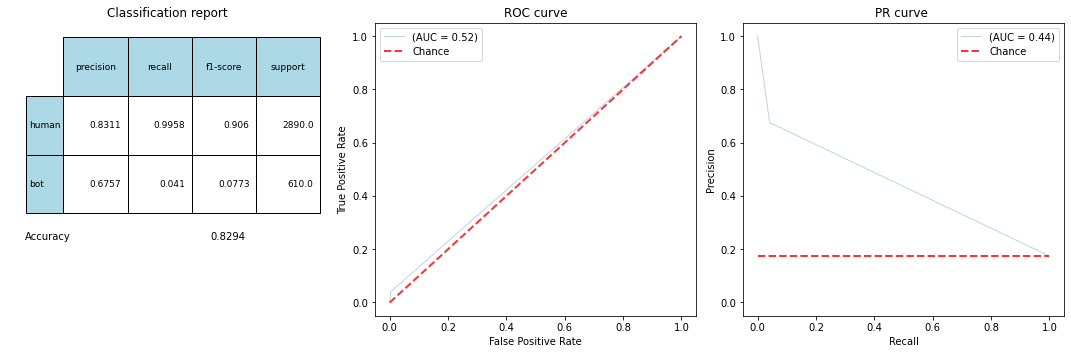

Imbalance compensation of 0.6:1


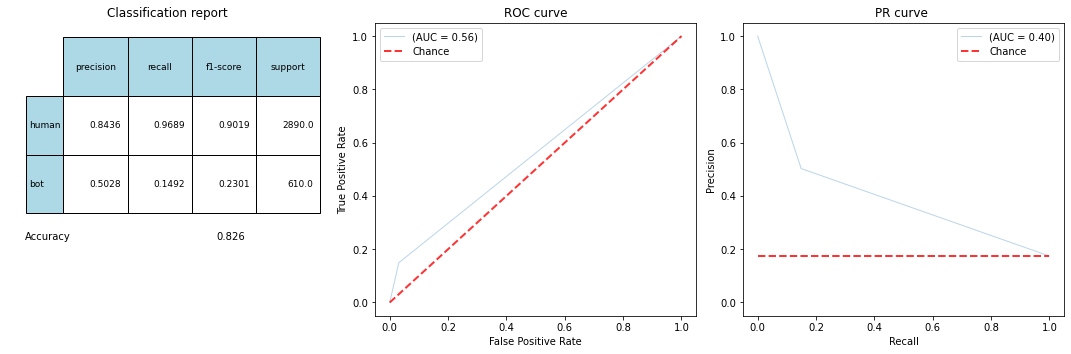

Imbalance compensation of 1.1:1


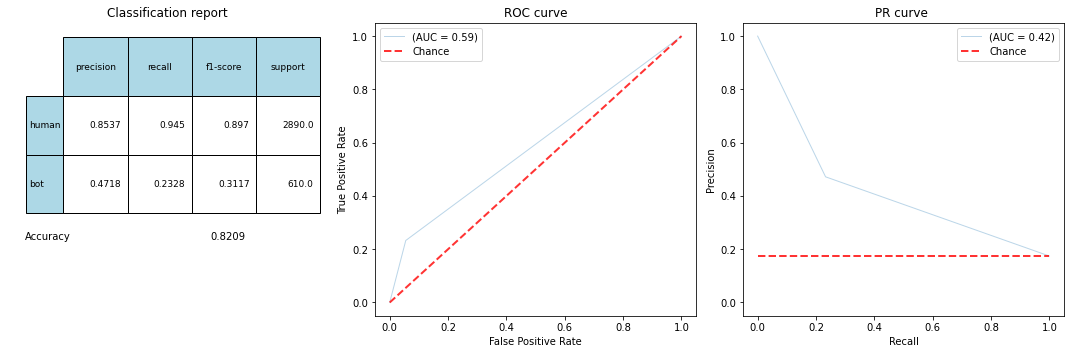

Imbalance compensation of 1.6:1


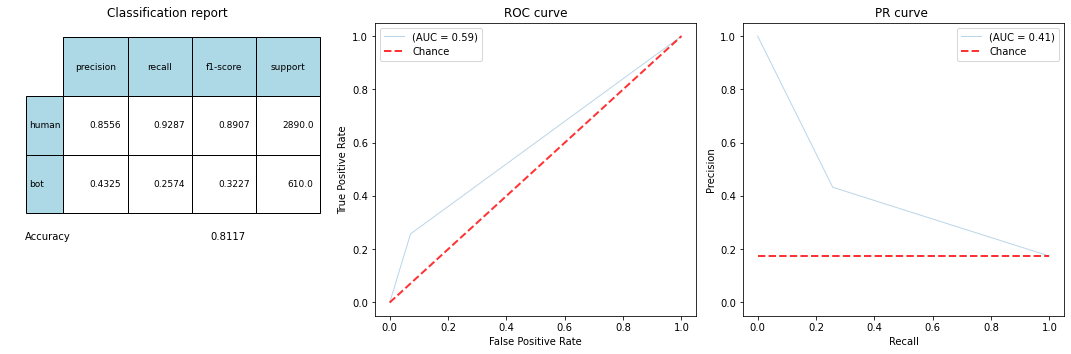

Imbalance compensation of 2.1:1


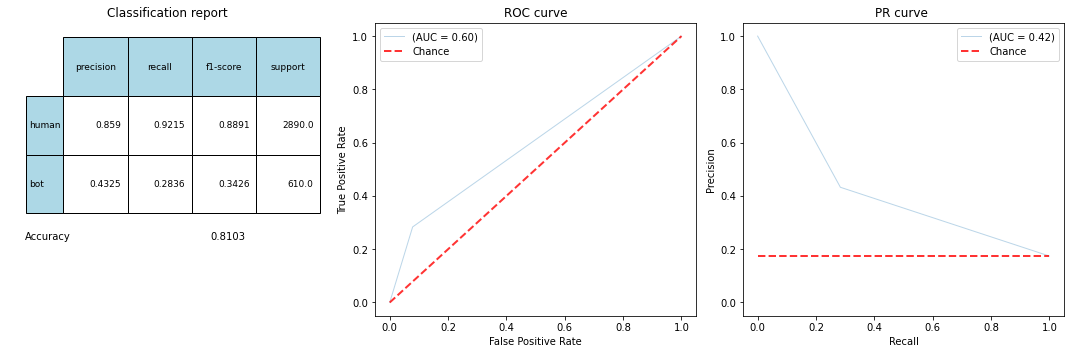

Imbalance compensation of 2.6:1


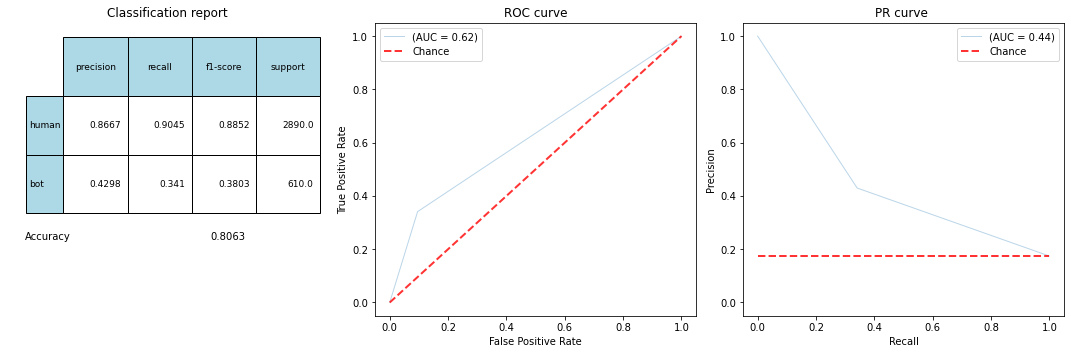

Imbalance compensation of 3.1:1


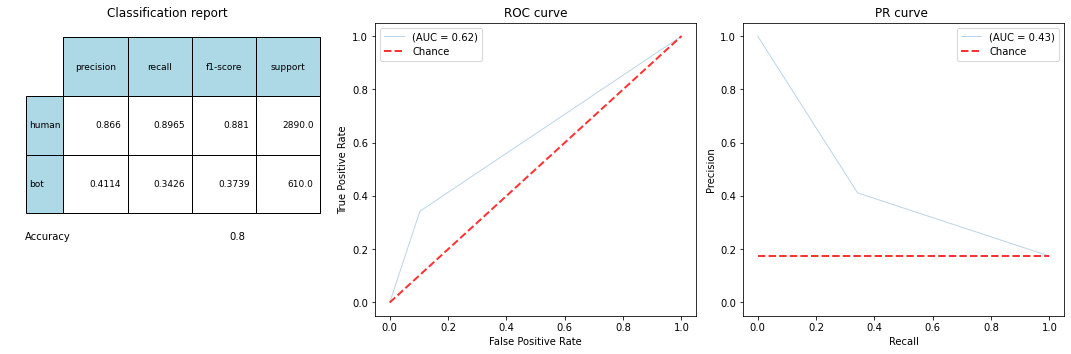

Imbalance compensation of 3.6:1


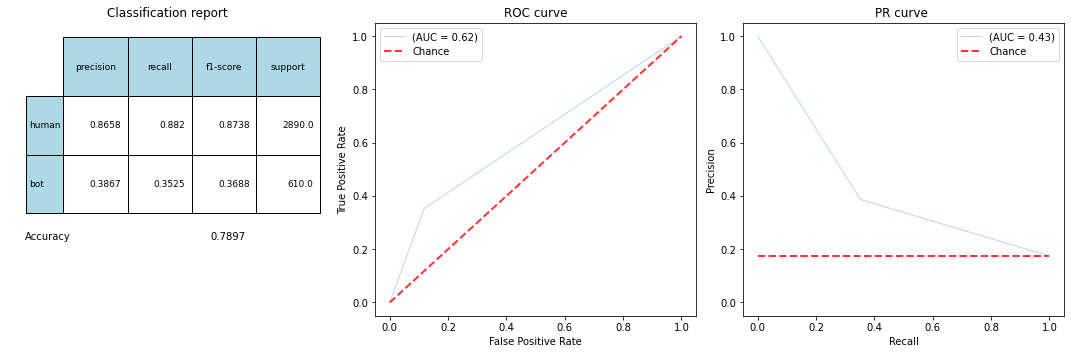

Imbalance compensation of 4.1:1


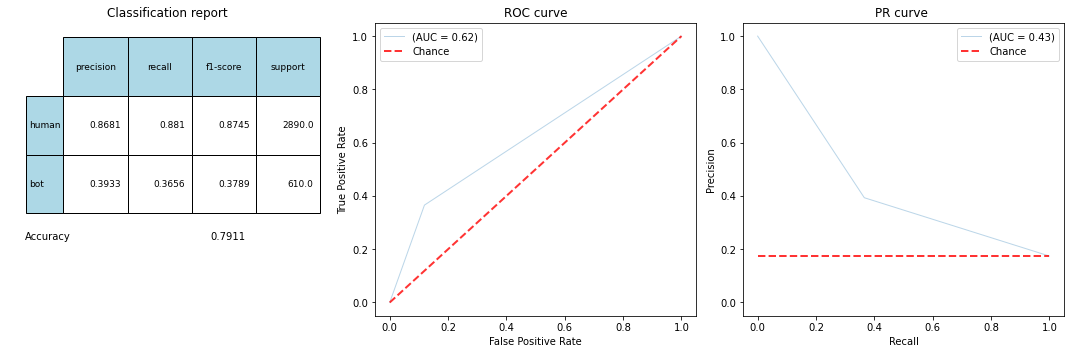

Imbalance compensation of 4.6:1


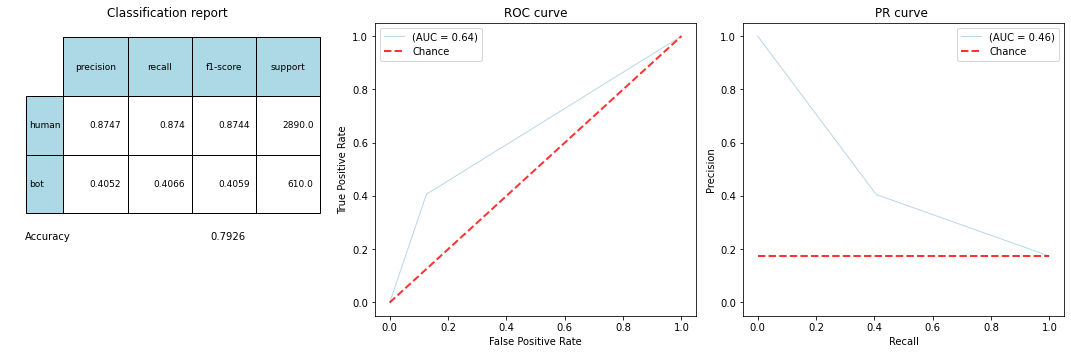

Imbalance compensation of 5.1:1


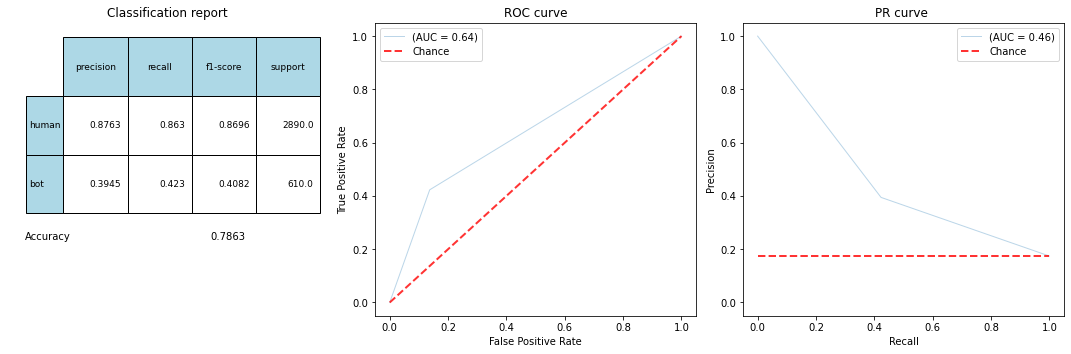

Imbalance compensation of 5.6:1


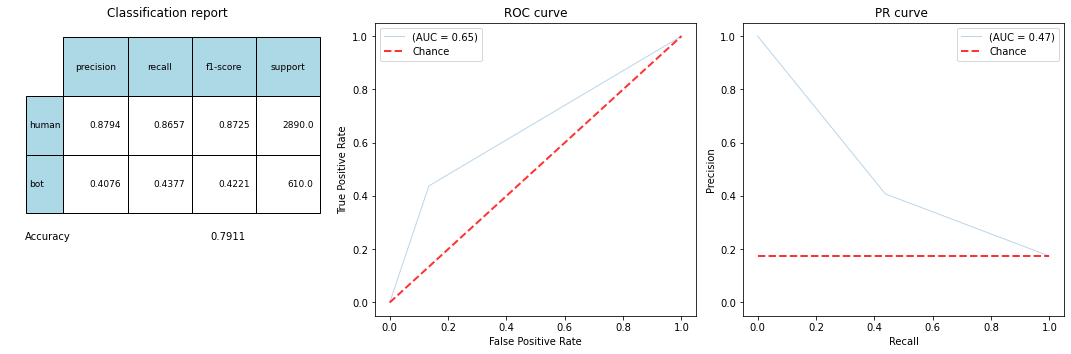

Imbalance compensation of 6.1:1


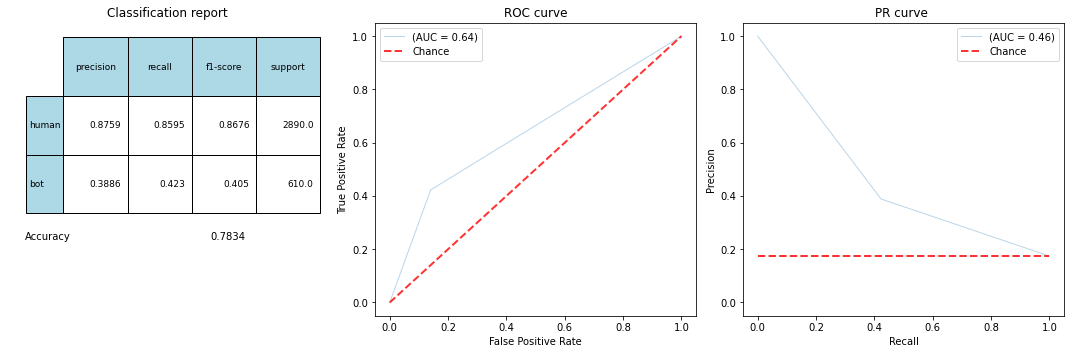

Imbalance compensation of 6.6:1


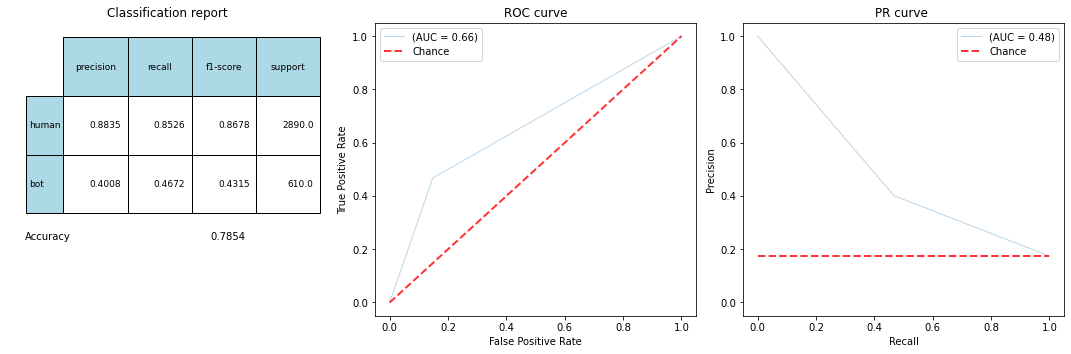

Imbalance compensation of 7.1:1


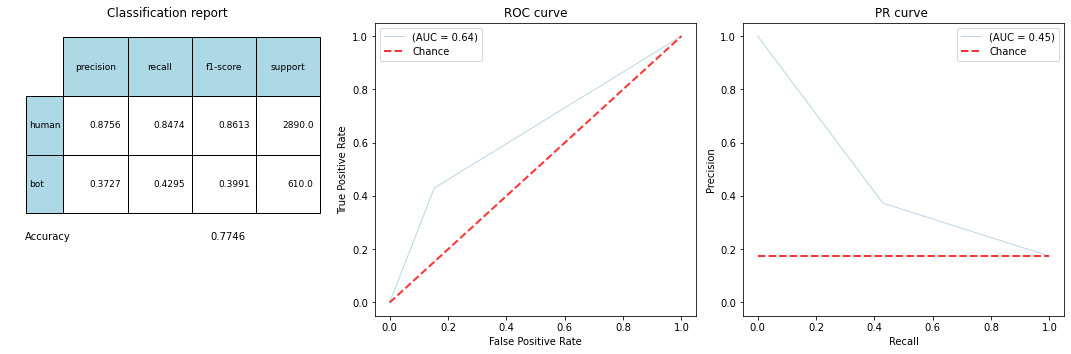

In [11]:
results_scale = {}
beta=0.5
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    print(f'Imbalance compensation of {scaling}:1')
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling
                        )
    xgb.fit(X_train, y_train)
    
    roc_auc, pr_auc, report, personalized_metrics = make_report(model = xgb,
                                                                y_test = y_test, 
                                                                x_test = X_test,  
                                                                include = ['class_report', 'roc', 'pr'], 
                                                                pad=1,
                                                                scale=5,
                                                                personalized = {f'f{beta}_score':fbeta_score},
                                                                **{'beta':beta, 'pos_label':1})

    results_scale[scaling] = {'roc_auc':roc_auc, 'pr_auc':pr_auc, 'report':report, 'personalized_metrics':personalized_metrics}
    

In [ ]:
del xgb, sc
sc = StandardScaler(with_mean=True)
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
predicted = xgb.predict(X_test_scaled)
print(classification_report(y_test,predicted))

In [ ]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)

In [ ]:
# weighting the classes to account for imbalancing
rf = RandomForestClassifier()

In [ ]:
n_samples / (n_classes * np.bincount(y))

# PCA to reduce dimentionality 

In [ ]:
# scale before PCA
# try with_mean = False
sc = StandardScaler(with_mean=True)
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
for j_features in [34, 24, 14, 4]:
    xgb = XGBClassifier()
    pca = PCA(n_components = j_features)
    X_train_scaled_pca = pca.fit_transform(X_train_scaled)
    xgb.fit(X_train_scaled_pca, y_train)
    X_test_scaled_transformed = pca.transform(X_test_scaled)
    predicted = xgb.predict(X_test_scaled_transformed)
    del xgb, pca
    print(j_features)
    print(classification_report(y_test,predicted))

In [ ]:
X_test_scaled = sc.transform(X_test)

In [ ]:
predicted = xgb.predict(X_test_scaled)
classification_report(y_Tes)

In [ ]:
print(classification_report(y_test,predicted))